# Import packages

In [1]:
# !pip install joblib
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import os
import glob
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from functions import *

pd.set_option("display.max_columns", None)

In [2]:
N_JOBS = -1
df_games = pd.read_csv("games_jan2024.csv")
df_games = df_games[['AppID', 'Name', 'Positive', 'Negative', "Estimated owners"]]

# Look at the data

In [3]:
game_review_files = glob.glob("SteamReviewsCombined/*.csv")
len(game_review_files)

71148

In [4]:
# Structure
pd.read_csv(game_review_files[0])

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
0,149154021,english,"Early access done right. Game is stable, game ...",1698611406,1698611406,True,0,0.000000,0,True,False,True,76561198018559321,0,8,14632,6378,14458,1698626368
1,149150184,english,The best 4x game I've ever played.\n\nSome imp...,1698607627,1698607627,True,0,0.000000,0,True,False,True,76561198027353332,74,2,20777,5237,20622,1698626260
2,149081843,french,1ère partie tuto de 15 h : abandonnée car j'av...,1698529963,1698577028,False,0,0.000000,0,False,False,True,76561198015592032,245,6,2414,2277,2062,1698598264
3,148103250,english,I just beat my first and last playthrough as T...,1697151065,1698520192,False,0,0.601064,0,True,False,True,76561198029253270,0,7,8851,4085,8851,1698519203
4,149041522,english,This game is awesome !\n\nIm not even halfway ...,1698491447,1698491447,True,0,0.000000,0,True,False,True,76561197963356626,0,15,4331,4105,3281,1698622656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4752,122873268,english,It's dangerous to go alone...You might need th...,1664206918,1664206918,True,0,0.547227,0,False,False,True,76561197977450937,710,114,2244,0,648,1664937259
4753,122873078,english,Supported the game on kickstarter and despite ...,1664206696,1664206696,True,0,0.523810,1,False,False,True,76561198077904734,250,17,6971,0,4671,1691240450
4754,122873074,english,"I had missed the kickstarter a few years ago, ...",1664206694,1664206694,True,1,0.794693,1,False,False,True,76561197997863731,489,16,35067,510,21631,1697578740
4755,122872823,english,"X-COM + Expanse + Grand Strategy\n\nYea, the g...",1664206356,1664206356,True,0,0.505747,0,False,False,True,76561198796499533,100,3,8243,0,7406,1687119788


## Features description

`recommendationid` - unique review ID  
`language` - language specified by the user when writing the review  
`review` - text of the review  
`timestamp_created` - date of review creation in UNIX format  
`timestamp_updated` - date of the last modification of the review in UNIX format  
`voted_up` - value true means that the review is positive  
`votes_funny` - number of users who found the review funny  
`weighted_vote_score` - usefulness rating  
`comment_count` - number of comments on this review  
`steam_purchase` - true if the user bought the game on Steam  
`received_for_free` - true, if the user checked the checkbox, which means that he/she got the application for free 
`written_during_early_access` - true if the review was written when the game was in early access  
`author_steamid` - user's SteamID  
`author_num_games_owned` - number of games the user owns  
`author_num_reviews` - number of reviews written by the user  
`author_playtime_forever` - time spent by the author in this application for the whole time  
`author_playtime_last_two_weeks` - time spent in this app in the last two weeks  
`author_playtime_at_review` - time spent in this app at the time of writing the review  
`author_last_played` - the last time the user launched the application in UNIX format.  

**Source:** https://partner.steamgames.com/doc/store/getreviews

# Part 1. Grouping by game

## Create functions and dataset for analysis

#### Create a dataframe where we will store data grouped by games

In [9]:
game_ids = list()
for game_file_path in game_review_files:
    steam_id = ''.join(re.findall(r'\d+', game_file_path))
    game_ids.append(steam_id)
len(game_ids)

71148

In [10]:
df = pd.DataFrame({'AppID': game_ids})
df['AppID'] = df['AppID'].astype(int)

### Fill the dataframe with features

In [11]:
for feature in ['voted_up', 
                'steam_purchase', 
                'received_for_free', 
                'written_during_early_access']:
    get_avg_by_feature(df, feature, N_JOBS, bool_feature=True)

Total time: 84.56943392753601
Total time: 86.1465060710907
Total time: 85.12010884284973
Total time: 80.61461019515991


In [12]:
for feature in ['author_num_games_owned', 
                'author_num_reviews', 
                'author_playtime_forever', 
                'author_playtime_last_two_weeks',
                'author_playtime_at_review']:
    get_avg_by_feature(df, feature, N_JOBS, bool_feature=False)

Total time: 86.09450817108154
Total time: 84.78841423988342
Total time: 89.33671188354492
Total time: 86.3495659828186
Total time: 90.33400011062622


### Final dataframe

In [13]:
df_games = pd.merge(df_games, df, on='AppID', how='inner')
df_games

,AppID,Name,Positive,Negative,Estimated owners,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
0,20200,Galactic Bowling,6,11,0 - 20000,0.352941,0.705882,0.000000,0.0,2285.294118,94.411765,196.941176,0.000000,NaN
1,655370,Train Bandit,53,5,0 - 20000,0.892308,0.830769,0.107692,0.0,690.015385,369.692308,80.015385,0.000000,62.892308
2,1355720,Henosis™,3,0,0 - 20000,1.000000,0.000000,0.400000,0.0,1370.400000,212.600000,96.600000,0.000000,96.600000
3,1139950,Two Weeks in Painland,50,8,0 - 20000,0.898305,0.593220,0.033898,0.0,286.779661,145.186441,515.915254,0.000000,418.983051
4,1469160,Wartune Reborn,87,49,50000 - 100000,0.663462,0.000000,0.125000,0.0,129.076923,222.168269,32824.980769,363.355769,15133.543269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71143,2513360,Kinny and the Star Track Puzzle,0,0,0 - 20000,1.000000,1.000000,0.000000,0.0,51.000000,4.000000,93.500000,0.000000,93.500000
71144,1619420,Diebrary,13,3,0 - 20000,0.757576,0.606061,0.333333,0.0,951.878788,177.393939,337.333333,0.606061,281.818182
71145,2224030,Flutter Away,0,0,0 - 0,0.863636,0.727273,0.068182,0.0,149.909091,44.113636,164.613636,2.022727,124.363636
71146,2524860,Spot the Object,2,1,0 - 20000,0.800000,0.600000,0.200000,0.0,4600.000000,155.000000,45.800000,0.000000,25.400000


In [14]:
df_games.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,AppID,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
count,7.114800e+04,7.114800e+04,71148.000000,71148.000000,71148.000000,71148.000000,71148.000000,7.114800e+04,7.114800e+04,71135.000000,71135.000000,61919.000000
mean,1.226345e+06,1.097078e+03,178.033564,0.740584,0.625439,0.093067,0.140561,4.291347e+03,4.788559e+02,1287.229734,10.946197,449.447866
std,6.291145e+05,2.651226e+04,4970.349916,0.235482,0.346179,0.150691,0.325188,5.858577e+05,2.799471e+04,5819.748655,85.242599,1561.888567
min,1.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,0.001074,0.000000,5.000000
1%,3.385580e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,9.000000,0.000000,8.000000
5%,3.019135e+05,0.000000e+00,0.000000,0.267072,0.000000,0.000000,0.000000,0.000000e+00,8.000000e+00,21.566667,0.000000,16.300000
10%,3.989270e+05,0.000000e+00,0.000000,0.417220,0.000000,0.000000,0.000000,6.120458e+01,1.600000e+01,37.122727,0.000000,25.714286
25%,7.011450e+05,1.000000e+00,0.000000,0.621193,0.389455,0.000000,0.000000,1.739134e+02,4.100000e+01,93.202273,0.000000,58.000000
50%,1.190085e+06,1.000000e+01,3.000000,0.800000,0.750000,0.036145,0.000000,3.829989e+02,1.186090e+02,264.017953,0.000000,144.031250
75%,1.731600e+06,6.100000e+01,18.000000,0.922731,0.911864,0.114286,0.000000,8.168813e+02,3.565890e+02,773.423706,1.272215,362.061522


## Plot the distributions

### language

In [15]:
language_counter = FeatureCounter('language', N_JOBS)
dict_languages = language_counter.get_all_feature_counts()

sorted_lang = sorted(dict_languages.items(), key=lambda item: item[1], reverse=True)
sorted_lang_df = pd.DataFrame(sorted_lang[:10], columns=['language', 'Count'])

Total time: 86.17917084693909


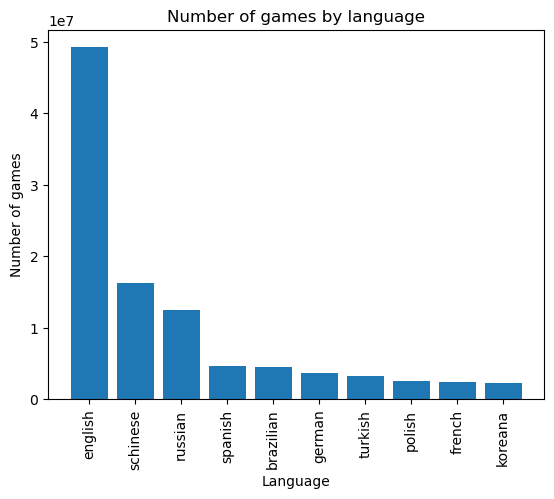

In [16]:
make_barplot('language', sorted_lang_df, 'Language', 
             'language', rotation=True, pre_counted = True)

### voted_up

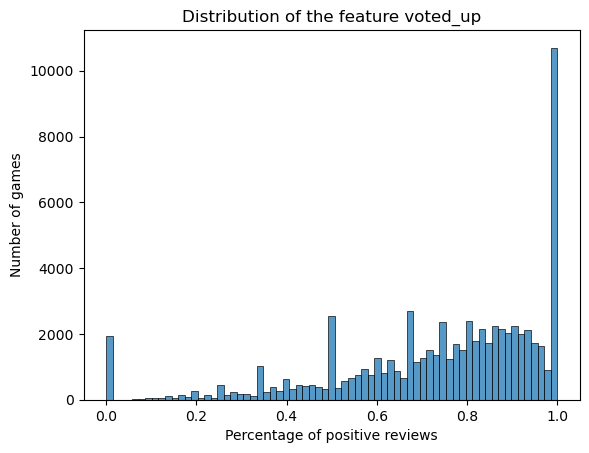

In [17]:
make_histplot('voted_up', df, 'Percentage of positive reviews', rotation=False)

**Most of the reviews in the dataset are positive**

In [18]:
# Top 10 games by reviews
df_games.sort_values(by='voted_up', ascending=False)[:10]

,AppID,Name,Positive,Negative,Estimated owners,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
36559,1012600,Why Chicken? Why?,1,0,0 - 20000,1.0,0.000000,0.000000,0.0,0.000000,2.000000,26.000000,0.000000,26.000000
10360,925050,Crystal Path,4,0,0 - 20000,1.0,1.000000,0.000000,0.0,207.833333,51.500000,1763.166667,217.833333,1256.833333
60988,1253010,Stella Pastoris,2,0,20000 - 50000,1.0,0.833333,0.000000,0.0,183.500000,15.500000,75.500000,0.000000,70.666667
60984,2107480,Hypogean,1,0,0 - 20000,1.0,1.000000,0.000000,0.0,0.000000,1.000000,159.000000,0.000000,130.000000
20970,1735090,Tea Time,2,0,0 - 20000,1.0,0.800000,0.000000,0.0,41.400000,34.200000,170.000000,0.000000,101.800000
60982,2129410,Salt Game,0,0,0 - 20000,1.0,1.000000,0.000000,0.0,99.666667,4.333333,879.333333,0.000000,126.666667
42593,623470,League of Light: Wicked Harvest Collector's Ed...,5,0,0 - 20000,1.0,0.800000,0.000000,0.0,23.200000,566.000000,612.600000,0.000000,399.600000
29025,1883750,Woodle Tree 2: Deluxe Plus,29,0,0 - 20000,1.0,0.666667,0.166667,0.0,1544.066667,219.533333,268.833333,0.000000,184.133333
24718,1675110,My Downtown,3,0,0 - 20000,1.0,1.000000,0.000000,0.0,0.000000,74.750000,732.000000,0.000000,248.500000
47637,1949490,YUMMY CHICKEN DRAGON,12,0,0 - 20000,1.0,0.722222,0.111111,0.0,198.444444,17.388889,96.500000,0.000000,62.833333


**It's important to keep in mind that "top" spots can be taken by games with only 1-2 positive reviews**

### steam_purchase

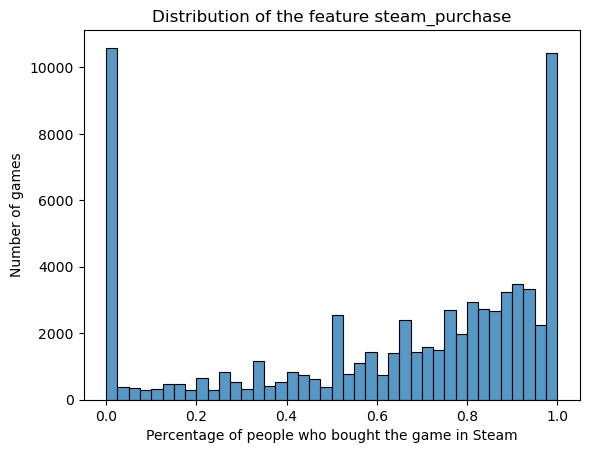

In [19]:
make_histplot('steam_purchase', df, 
              'Percentage of people who bought the game in Steam', rotation=False)

**Most of the games are bought on steam, but there are a lot of reviews for games that were bought outside of steam as well**

In [20]:
# Top 10 games in terms of purchase on Steam
df_games.sort_values(by='steam_purchase', ascending=False)[:10]

,AppID,Name,Positive,Negative,Estimated owners,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
17080,726230,The Superlatives: Aetherfall,22,2,0 - 20000,0.880000,1.0,0.000000,0.0,178.960000,38.800000,978.800000,0.0,NaN
8110,1704620,Harrier Jump Jet,1,0,0 - 20000,1.000000,1.0,0.000000,0.0,1056.500000,1233.000000,10.000000,0.0,10.000000
52306,764720,Oh No! Ninjas!,2,0,0 - 20000,0.666667,1.0,0.000000,0.0,2856.666667,3485.000000,21.000000,0.0,21.000000
57693,1726590,Marble Mage,8,1,0 - 20000,0.909091,1.0,0.000000,0.0,328.727273,53.000000,622.090909,0.0,168.818182
64572,2279270,The Duduk Master,0,0,0 - 0,0.000000,1.0,0.000000,0.0,150.000000,25.000000,25.000000,0.0,25.000000
45431,1371110,labyrinth 2,5,0,0 - 20000,1.000000,1.0,0.000000,0.0,189.250000,45.750000,61.750000,0.0,32.000000
64569,2269350,MrWang And Love,0,0,0 - 0,0.166667,1.0,0.000000,0.0,470.166667,36.833333,260.166667,0.0,189.500000
52303,498460,Abduction Prologue: The Story Of Jonathan Blake,1,10,0 - 20000,0.090909,1.0,0.090909,0.0,795.636364,577.181818,26.727273,0.0,21.181818
45435,1573330,Unreal Sandbox,2,1,0 - 20000,0.666667,1.0,0.000000,0.0,49.000000,15.666667,203.000000,0.0,38.333333
64566,2296270,Sex Adventures - The Job Promotion,0,0,0 - 20000,0.500000,1.0,0.000000,0.0,0.000000,1535.000000,12.000000,0.0,11.500000


### received_for_free

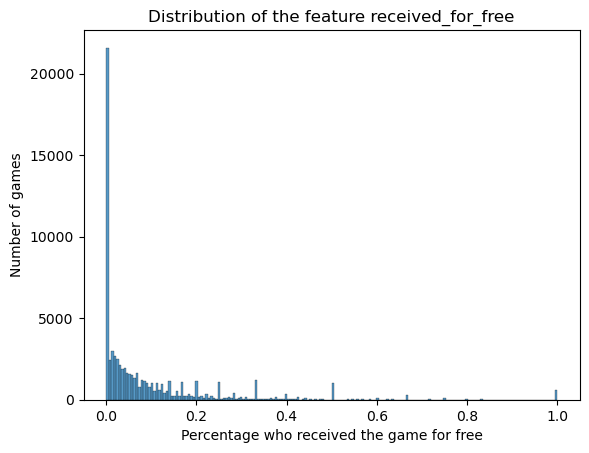

In [21]:
make_histplot('received_for_free', df, 
              'Percentage who received the game for free', rotation=False)

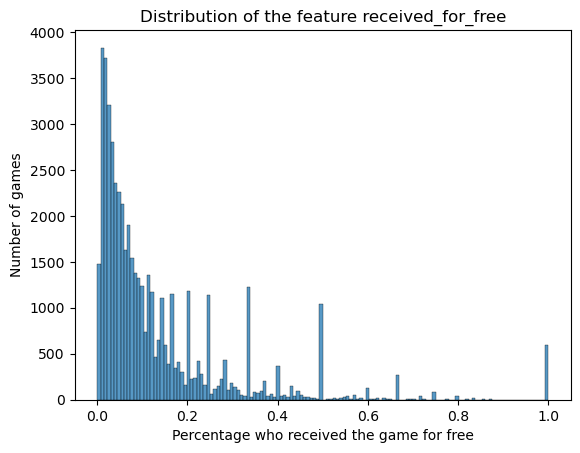

In [22]:
make_histplot('received_for_free', df[df['received_for_free'] > 0], 
              'Percentage who received the game for free', rotation=False)

**Mostly people buy games, not get them for free**

In [23]:
# Top 10 games by the number of people who get them for free
df_games.sort_values(by='received_for_free', ascending=False)[:10]

,AppID,Name,Positive,Negative,Estimated owners,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
26479,994170,Statue Defender,1,1,0 - 20000,0.50,0.0,1.0,0.00,1029.00,2265.00,26.0,0.0,13.0
50353,1241810,Bowmen,1,0,20000 - 50000,1.00,0.0,1.0,1.00,0.00,1.00,76.0,0.0,41.0
4701,1241690,Fatal Wings,1,0,0 - 20000,1.00,0.0,1.0,0.00,0.00,12.00,45.0,0.0,37.0
64142,2234610,winVGF,0,0,0 - 20000,0.00,0.0,1.0,0.00,1297.00,36.00,6.0,0.0,6.0
50503,1354970,DNA Farm,1,0,0 - 20000,1.00,0.0,1.0,0.00,630.00,1037.00,8.0,0.0,8.0
50481,1192950,Qi Qiang,2,1,0 - 20000,0.50,0.0,1.0,0.00,1139.50,2273.50,144.5,0.0,124.5
4654,1526360,Customers From Hell - Game For Retail Workers ...,1,0,0 - 20000,0.75,0.0,1.0,0.25,816.25,553.25,32.5,0.0,32.5
40977,1559770,Microgravity,0,1,0 - 20000,0.00,0.0,1.0,0.00,935.00,138.00,7.0,0.0,7.0
64205,2252870,Tactical Vengeance: Play The Game,0,0,0 - 20000,1.00,0.0,1.0,1.00,55.00,1.00,350.0,17.0,23.0
4630,1354800,Really Bad Flying Machine,1,0,0 - 20000,1.00,0.0,1.0,0.00,11.00,4.00,494.0,0.0,32.0


### written_during_early_access

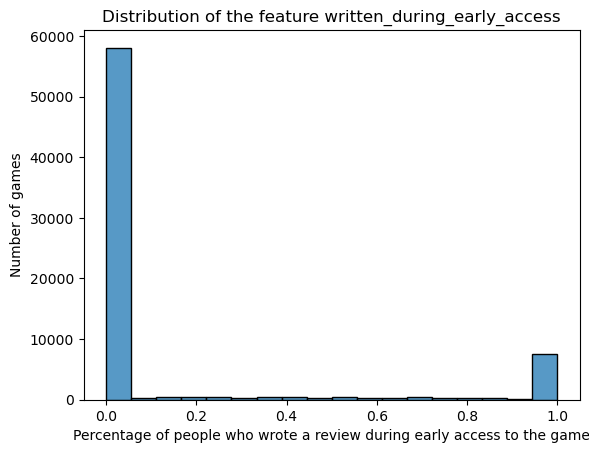

In [24]:
make_histplot('written_during_early_access', df, 
              'Percentage of people who wrote a review during early access to the game', 
              rotation=False)

**Most of the reviews are not written during early access to the game**

In [25]:
# Top 10 games based on the number of reviews written during early access to the game
df_games.sort_values(by='written_during_early_access', ascending=False)[:10]

,AppID,Name,Positive,Negative,Estimated owners,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
67792,1267210,Together in Battle,7,1,20000 - 50000,0.916667,0.916667,0.083333,1.0,256.750000,43.916667,1856.833333,48.333333,1148.625000
66773,1915510,Yao-Guai Hunter,0,0,0 - 0,0.842885,0.910079,0.025692,1.0,134.513834,31.266798,1932.063241,40.339921,796.162055
18847,1672930,梅斯特姆,6,8,20000 - 50000,0.470588,1.000000,0.000000,1.0,181.647059,12.176471,277.117647,2.941176,110.823529
35658,719470,Demon And Fairy,7,9,0 - 20000,0.470588,0.941176,0.058824,1.0,797.823529,251.176471,113.705882,0.000000,99.411765
11047,943590,BlitzKeep Unleashed,6,1,0 - 20000,0.857143,0.714286,0.285714,1.0,615.857143,388.428571,236.142857,0.000000,167.142857
5365,365290,House of Nightmares B-Movie Edition,3,1,0 - 20000,0.600000,0.600000,0.000000,1.0,1158.600000,140.800000,42.600000,0.000000,42.400000
66777,774801,Crab Champions,1211,19,0 - 20000,0.948980,0.887755,0.040816,1.0,60.724490,10.193878,2299.795918,670.959184,2095.683673
26836,1499750,The Frost Rebirth,8,15,0 - 20000,0.400000,0.600000,0.200000,1.0,937.080000,115.600000,136.280000,1.800000,110.440000
62194,1955100,怯懦 Cowardice,3,0,0 - 20000,0.750000,0.750000,0.000000,1.0,1731.750000,844.000000,31.000000,0.000000,31.000000
31954,761880,The Day They Landed,1,3,0 - 20000,0.250000,0.250000,0.750000,1.0,1533.500000,269.750000,99.250000,0.000000,26.250000


### author_num_games_owned

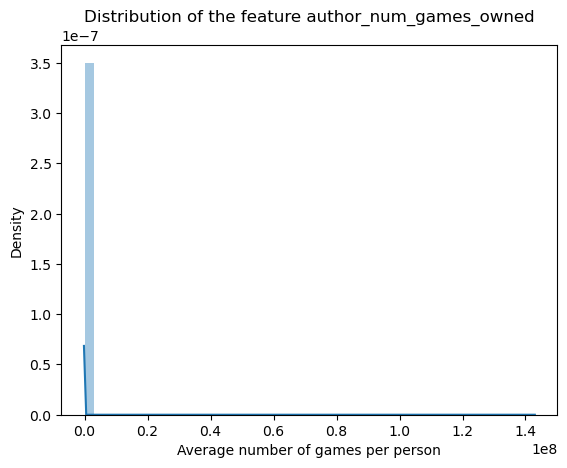

In [26]:
make_distplot('author_num_games_owned', df, 
              'Average number of games per person', rotation=False)

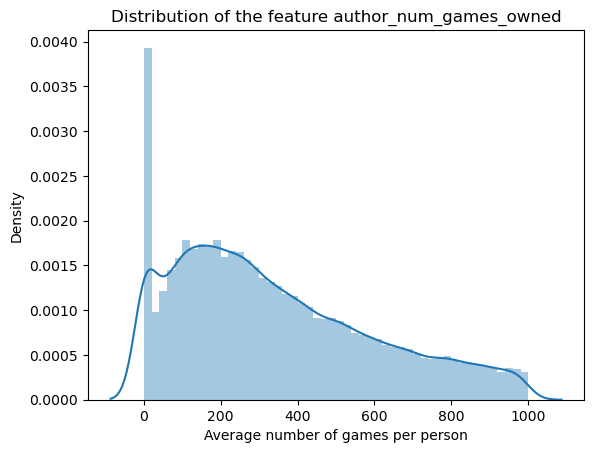

In [27]:
make_distplot('author_num_games_owned', df[df['author_num_games_owned'] < 1000], 
              'Average number of games per person', rotation=False)

**We can see from the graphs that the average number of games per person can be 1000 or more. There are likely to be outliers in the data and lots of them**

In [28]:
lower_bound = df['author_num_games_owned'].quantile(q=0.025)
upper_bound = df['author_num_games_owned'].quantile(q=0.975)
print('Number of outliers by interquantile criterion:', 
      len(df[(df['author_num_games_owned'] < lower_bound) | 
             (df['author_num_games_owned'] > upper_bound)]),
     '\nPercentage of outliers:', 
      100*len(df[(df['author_num_games_owned'] < lower_bound) | 
                 (df['author_num_games_owned'] > upper_bound)])/len(df), '%')

Number of outliers by interquantile criterion: 1779 
Percentage of outliers: 2.500421656265812 %


In [29]:
# Top 10 games by number of reviews from people who own a lot of games
df_games.sort_values(by='author_num_games_owned', ascending=False)[:10]

,AppID,Name,Positive,Negative,Estimated owners,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
630,40800,Super Meat Boy,28651,1554,2000000 - 5000000,0.947503,0.745601,0.011298,0.0,1.427847e+08,25.192877,1212.256250,9.692812,NaN
26441,1158310,Crusader Kings III,71574,5380,2000000 - 5000000,0.918812,0.655040,0.012814,0.0,4.423583e+07,11.671002,12673.198696,297.739346,6539.552870
9500,236850,Europa Universalis IV,93164,14604,2000000 - 5000000,0.867716,0.684575,0.011673,0.0,3.535675e+07,9.387239,52847.411083,420.271877,NaN
56771,48700,Mount & Blade: Warband,140048,3220,2000000 - 5000000,0.976784,0.803269,0.012464,0.0,2.808203e+07,11.767315,20536.570290,98.082138,NaN
32034,945360,Among Us,577656,51069,20000000 - 50000000,0.921361,0.880042,0.044690,0.0,6.160124e+06,6.955957,2681.040410,62.709188,1446.397225
43279,1787140,RagingFist,0,0,0 - 20000,0.000000,1.000000,0.000000,0.0,3.000000e+04,171.000000,40.000000,0.000000,40.000000
3533,1195250,Gateball VR,0,1,0 - 20000,0.000000,1.000000,0.000000,0.0,2.556100e+04,270.000000,16.000000,0.000000,16.000000
68113,2363670,Watchers of the Universe: I'm outta here!,0,0,0 - 20000,1.000000,0.000000,1.000000,0.0,2.091200e+04,254.000000,330.000000,0.000000,330.000000
60531,2086090,Violet's Party Mania,1,0,0 - 20000,1.000000,0.000000,1.000000,0.0,2.091100e+04,254.000000,274.000000,0.000000,274.000000
59442,1710790,Finley's - The Colour of Radiation,0,0,0 - 20000,1.000000,0.000000,1.000000,0.0,2.091100e+04,254.000000,112.000000,0.000000,93.000000


### author_num_reviews

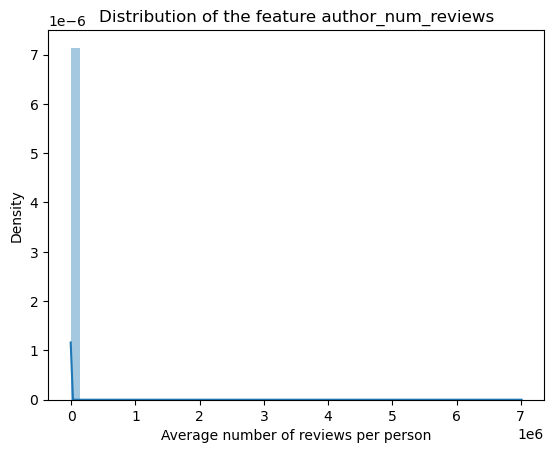

In [30]:
make_distplot('author_num_reviews', df, 
              'Average number of reviews per person', rotation=False)

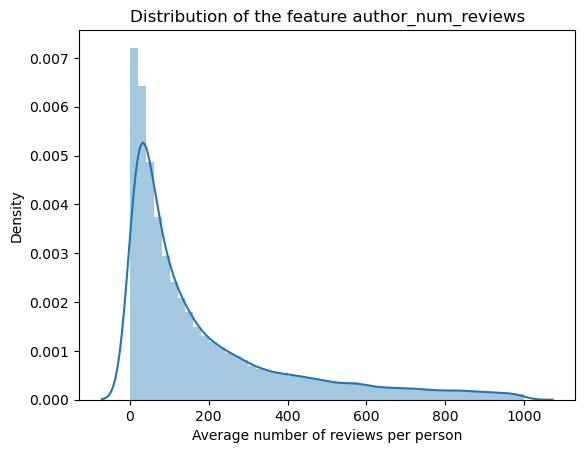

In [31]:
make_distplot('author_num_reviews', df[df['author_num_reviews'] < 1000], 
              'Average number of reviews per person', rotation=False)

**Mostly people write less than 200 reviews. However, we see that there are values of 1000 reviews and more, which means that there are emissions**

In [32]:
lower_bound = df['author_num_reviews'].quantile(q=0.025)
upper_bound = df['author_num_reviews'].quantile(q=0.975)
print('Number of outliers by interquantile criterion:', 
      len(df[(df['author_num_reviews'] < lower_bound) | 
             (df['author_num_reviews'] > upper_bound)]),
     '\nPercentage of outliers:', 
      100*len(df[(df['author_num_reviews'] < lower_bound) | 
                 (df['author_num_reviews'] > upper_bound)])/len(df), '%')

Number of outliers by interquantile criterion: 3506 
Percentage of outliers: 4.927756226457525 %


In [33]:
# Top 10 games that were reviewed by people who generally write a lot of reviews
df_games.sort_values(by='author_num_reviews', ascending=False)[:10]

,AppID,Name,Positive,Negative,Estimated owners,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
57077,413150,Stardew Valley,475785,8983,10000000 - 20000000,0.980743,0.846578,0.020197,0.0,96.744012,7.003545e+06,NaN,NaN,NaN
54014,271590,Grand Theft Auto V,1171197,210154,20000000 - 50000000,0.857158,0.908470,0.042772,0.0,63.136644,2.585757e+06,18596.801689,237.419697,NaN
62066,2197170,Aswang Detective: The Case of New York,0,0,0 - 20000,0.000000,0.000000,0.000000,0.0,8529.000000,1.043600e+04,13.000000,0.000000,13.0
47327,1913020,Astra Wing,0,0,0 - 20000,0.000000,1.000000,0.000000,0.0,8529.000000,1.043600e+04,244.000000,0.000000,244.0
28767,1168160,Piping Hot,0,0,0 - 20000,0.000000,0.000000,0.000000,0.0,8529.000000,1.043600e+04,14.000000,0.000000,14.0
35441,1308450,Halloween Horrors Deluxe Steam Edition,0,0,0 - 20000,0.000000,0.000000,0.000000,0.0,8529.000000,1.043600e+04,5.000000,0.000000,5.0
5454,1976590,Eternal Space,0,0,0 - 20000,0.000000,0.000000,0.000000,1.0,8529.000000,1.043600e+04,493.000000,0.000000,87.0
64299,2267010,Kong Hero,0,0,0 - 20000,0.000000,0.000000,0.000000,1.0,8529.000000,1.043600e+04,38.000000,0.000000,38.0
24085,854530,Paper Shakespeare: Stick Julius Caesar (with a...,0,0,0 - 20000,0.000000,0.000000,0.000000,0.0,8529.000000,1.043400e+04,8.000000,0.000000,8.0
63531,2239250,Space Fighter,0,0,0 - 20000,0.000000,0.000000,0.000000,1.0,8529.000000,1.043400e+04,41.000000,0.000000,41.0


### author_playtime_forever

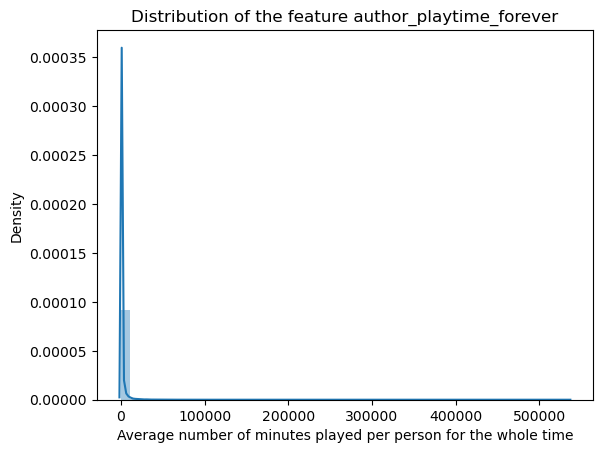

In [34]:
make_distplot('author_playtime_forever', df, 
              'Average number of minutes played per person for the whole time', rotation=False)

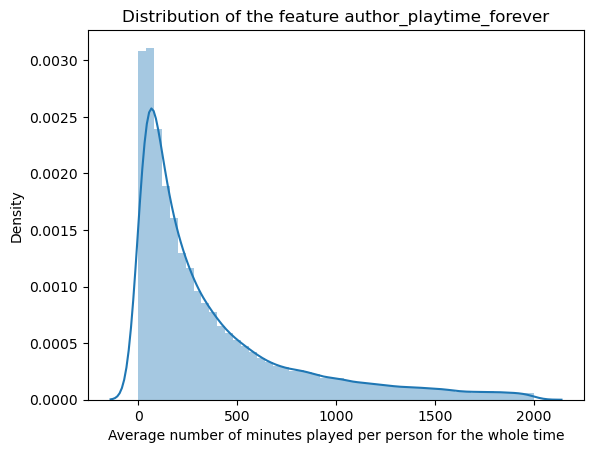

In [35]:
make_distplot('author_playtime_forever', df[df['author_playtime_forever'] < 2000], 
              'Average number of minutes played per person for the whole time', rotation=False)

**Most people play up to 500 minutes in one game, there are also outliers**

In [36]:
lower_bound = df['author_playtime_forever'].quantile(q=0.025)
upper_bound = df['author_playtime_forever'].quantile(q=0.975)
print('Number of outliers by interquantile criterion:', 
      len(df[(df['author_playtime_forever'] < lower_bound) | 
             (df['author_playtime_forever'] > upper_bound)]),
     '\nPercentage of outliers:', 
      100*len(df[(df['author_playtime_forever'] < lower_bound) | 
                 (df['author_playtime_forever'] > upper_bound)])/len(df), '%')

Number of outliers by interquantile criterion: 3475 
Percentage of outliers: 4.884185078990273 %


In [37]:
# Top 10 games by the amount of time players spend playing them
df_games.sort_values(by='author_playtime_forever', ascending=False)[:10]

,AppID,Name,Positive,Negative,Estimated owners,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
15658,1427540,Attack from Planet Smiley,1,0,0 - 20000,1.000000,1.000000,0.000000,0.0,179.000000,28.000000,535126.000000,2951.000000,41741.000000
27938,1912760,The Hentai Memory,0,0,0 - 20000,0.793103,0.086207,0.068966,0.0,320.672414,216.431034,461955.362069,5667.155172,31655.068966
14669,466170,Idling to Rule the Gods,1124,161,200000 - 500000,0.872258,0.010968,0.057419,0.0,223.584516,74.887097,289746.129677,1395.238710,NaN
56694,402840,Crusaders of the Lost Idols,2348,455,200000 - 500000,0.832050,0.016795,0.025892,0.0,493.899930,76.994052,230394.385584,231.775367,NaN
47,718350,Loot Collection: Mahjong,2,3,20000 - 50000,0.500000,1.000000,0.000000,0.0,1888.250000,1668.250000,218959.875000,0.000000,96636.000000
16756,663090,Granado Espada,594,396,100000 - 200000,0.617569,0.059450,0.086957,0.0,68.740018,71.780834,213534.001775,758.241349,NaN
37723,946400,Slime Quest,5,2,0 - 20000,0.714286,0.428571,0.142857,0.0,390.142857,614.000000,213395.714286,0.000000,16617.571429
9321,1011510,Wizard And Minion Idle,539,57,50000 - 100000,0.910355,0.000000,0.040185,0.0,242.545595,95.981453,211040.615147,476.683153,NaN
55747,805470,CubicPanic,1,0,0 - 20000,1.000000,1.000000,0.000000,0.0,0.000000,2385.000000,194999.000000,0.000000,77.000000
9770,1147690,NGU IDLE,8577,332,500000 - 1000000,0.962300,0.000000,0.069052,0.0,199.508271,25.319196,170514.340739,784.731583,52354.621562


### author_playtime_last_two_weeks

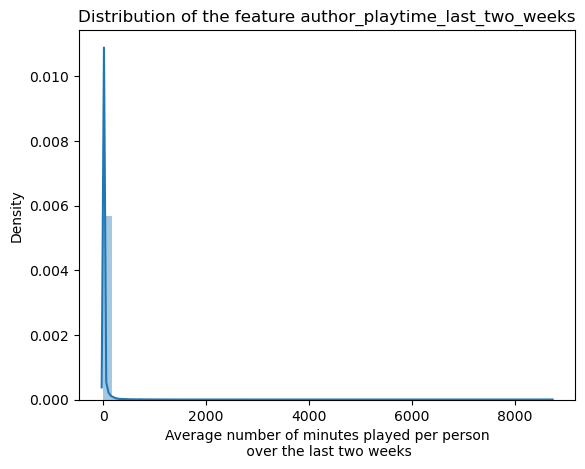

In [38]:
make_distplot('author_playtime_last_two_weeks', df, 
              'Average number of minutes played per person\n over the last two weeks', rotation=False)

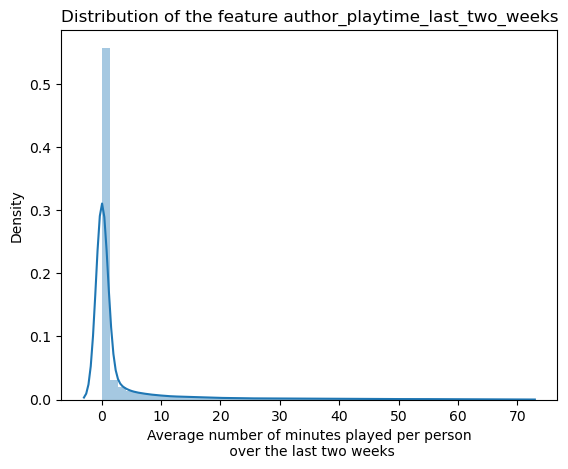

In [39]:
make_distplot('author_playtime_last_two_weeks', df[df['author_playtime_last_two_weeks'] < 70], 
              'Average number of minutes played per person\n over the last two weeks', rotation=False)

**Most of the minutes played in the last two weeks are under 30, which is fine, but there are a few outliers here**.

In [40]:
lower_bound = df['author_playtime_last_two_weeks'].quantile(q=0.025)
upper_bound = df['author_playtime_last_two_weeks'].quantile(q=0.975)
print('Number of outliers by interquantile criterion:', 
      len(df[(df['author_playtime_last_two_weeks'] < lower_bound) | 
             (df['author_playtime_last_two_weeks'] > upper_bound)]),
     '\nPercentage of outliers:', 
      100*len(df[(df['author_playtime_last_two_weeks'] < lower_bound) | 
                 (df['author_playtime_last_two_weeks'] > upper_bound)])/len(df), '%')

Number of outliers by interquantile criterion: 1779 
Percentage of outliers: 2.500421656265812 %


In [41]:
# Top 10 games by the amount of time players have spent in them in the last two weeks
df_games.sort_values(by='author_playtime_last_two_weeks', ascending=False)[:10]

,AppID,Name,Positive,Negative,Estimated owners,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
17770,1661690,Inflatable doll,8,10,0 - 20000,0.971698,0.968553,0.018868,0.0,100.962264,45.393082,9117.814465,8703.066038,225.487421
70994,2496860,修仙小屋,0,0,0 - 0,0.751724,0.000000,0.158621,0.0,109.213793,30.006897,39773.234483,5671.689655,8980.331034
67813,2389930,"Ayase, the Sexy Archer",0,0,0 - 0,0.962963,0.814815,0.018519,0.0,235.129630,92.981481,41606.037037,5667.425926,2560.611111
27938,1912760,The Hentai Memory,0,0,0 - 20000,0.793103,0.086207,0.068966,0.0,320.672414,216.431034,461955.362069,5667.155172,31655.068966
907,1102140,Glizzy Gobbler,1,0,0 - 20000,0.750000,1.000000,0.000000,0.0,75.500000,10.750000,12582.250000,4980.500000,3477.000000
43614,1283970,YoloMouse,902,67,200000 - 500000,0.938874,0.977335,0.005495,0.0,169.578984,12.688187,138426.622940,3079.730769,62113.324863
62031,2115630,CyberLink PowerDirector 21 Ultimate,0,0,0 - 20000,0.800000,1.000000,0.000000,0.0,48.400000,5.600000,13442.800000,3025.800000,7405.600000
15658,1427540,Attack from Planet Smiley,1,0,0 - 20000,1.000000,1.000000,0.000000,0.0,179.000000,28.000000,535126.000000,2951.000000,41741.000000
17671,1962930,Jacks or Better - Video Poker,1,0,0 - 20000,1.000000,0.714286,0.285714,0.0,1269.571429,191.000000,54397.000000,2875.142857,356.285714
57738,1950140,SAVE THE SCHOOL FLOWER ACTION,3,3,0 - 20000,0.500000,0.666667,0.333333,0.0,668.500000,112.666667,82881.000000,2692.666667,587.000000


### author_playtime_at_review

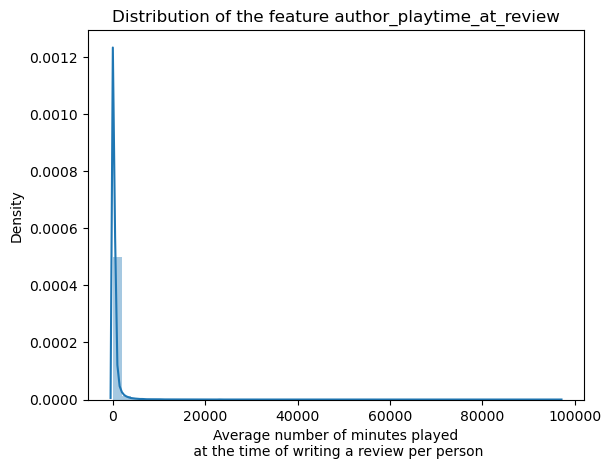

In [42]:
make_distplot('author_playtime_at_review', df, 
              'Average number of minutes played\n at the time of writing a review per person', 
              rotation=False)

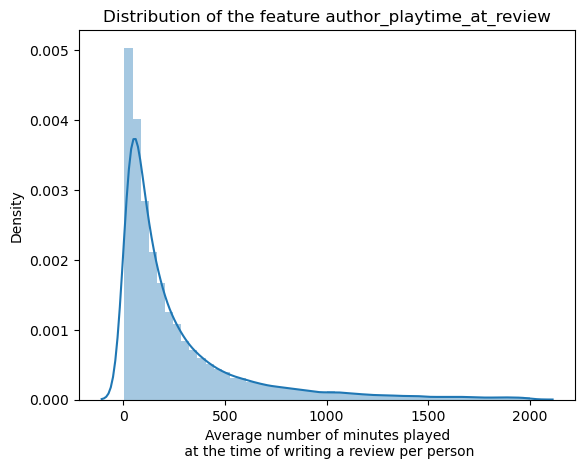

In [43]:
make_distplot('author_playtime_at_review', df[df['author_playtime_at_review'] < 2000], 
              'Average number of minutes played\n at the time of writing a review per person', 
              rotation=False)

In [44]:
lower_bound = df['author_playtime_at_review'].quantile(q=0.025)
upper_bound = df['author_playtime_at_review'].quantile(q=0.975)
print('Number of outliers by interquantile criterion:', 
      len(df[(df['author_playtime_at_review'] < lower_bound) | 
             (df['author_playtime_at_review'] > upper_bound)]),
     '\nPercentage of outliers:', 
      100*len(df[(df['author_playtime_at_review'] < lower_bound) | 
                 (df['author_playtime_at_review'] > upper_bound)])/len(df), '%')

Number of outliers by interquantile criterion: 3095 
Percentage of outliers: 4.350087142294934 %


In [45]:
# Top 10 games by the amount of time players have spent playing them at the time of writing the review
df_games.sort_values(by='author_playtime_at_review', ascending=False)[:10]

,AppID,Name,Positive,Negative,Estimated owners,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
47,718350,Loot Collection: Mahjong,2,3,20000 - 50000,0.500000,1.000000,0.000000,0.000000,1888.250000,1668.250000,218959.875000,0.000000,96636.000000
22196,530300,Slymes,6,1,0 - 20000,0.857143,0.714286,0.000000,0.000000,664.857143,266.571429,90683.857143,0.000000,89989.571429
52329,1081100,Insurgence - Second Assault,19,0,0 - 20000,1.000000,0.789474,0.105263,0.000000,248.631579,131.684211,90110.789474,783.473684,72540.842105
43614,1283970,YoloMouse,902,67,200000 - 500000,0.938874,0.977335,0.005495,0.000000,169.578984,12.688187,138426.622940,3079.730769,62113.324863
39134,25860,Sword of the Stars: Complete Collection,369,49,0 - 20000,0.500000,1.000000,0.000000,0.000000,0.000000,10.000000,66074.750000,0.000000,61647.250000
40341,1269900,snake::reloaded,0,0,0 - 20000,1.000000,1.000000,0.000000,0.000000,6700.000000,61.000000,60007.000000,0.000000,60007.000000
45177,38020,Mahjong Quest Collection,20,2,0 - 20000,1.000000,1.000000,0.000000,0.000000,28.333333,4.333333,83203.222222,44.333333,57782.444444
9770,1147690,NGU IDLE,8577,332,500000 - 1000000,0.962300,0.000000,0.069052,0.000000,199.508271,25.319196,170514.340739,784.731583,52354.621562
47714,468070,90 Minute Fever - Online Football (Soccer) Man...,155,95,20000 - 50000,0.638989,0.379061,0.054152,0.963899,280.480144,194.613718,113116.602888,260.411552,44270.584838
52673,933540,Idle Space Raider,153,52,50000 - 100000,0.744186,0.000000,0.041860,0.000000,442.176744,219.948837,111855.632558,50.241860,41817.386047


## Correlation analysis

In [46]:
df_games = df_games.select_dtypes([int, float])

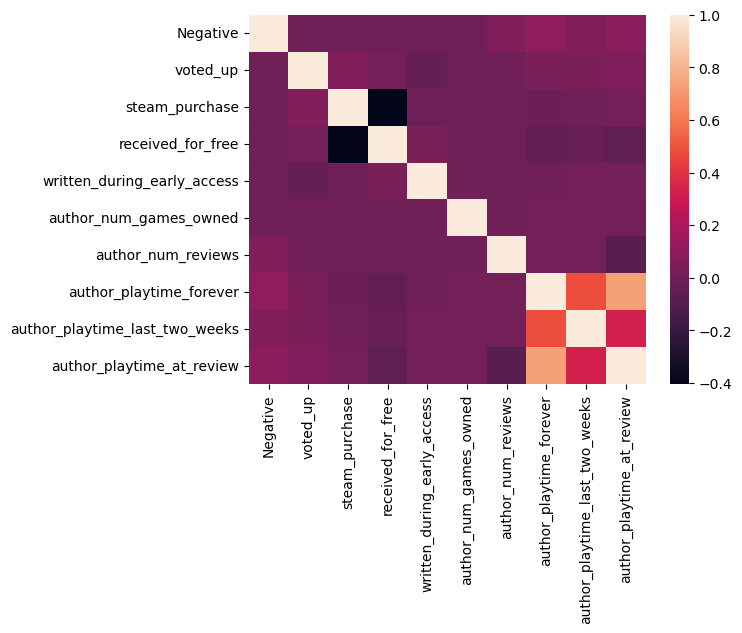

In [47]:
corr_matrix = df_games.iloc[:, 2:].corr()
sns.heatmap(corr_matrix)
plt.show()

## Plot the plots of correlated features

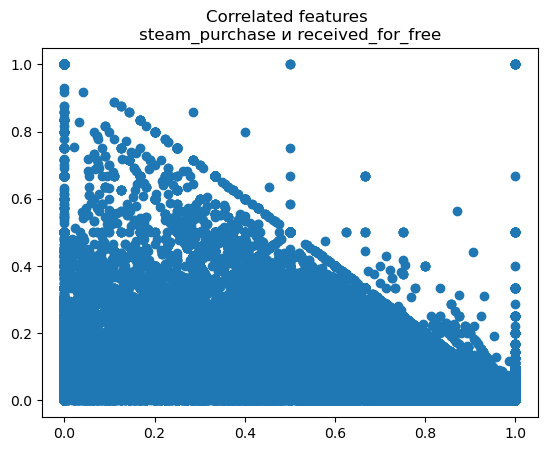

In [48]:
plot_correlated_features(df_games, 'steam_purchase', 
                         'received_for_free')

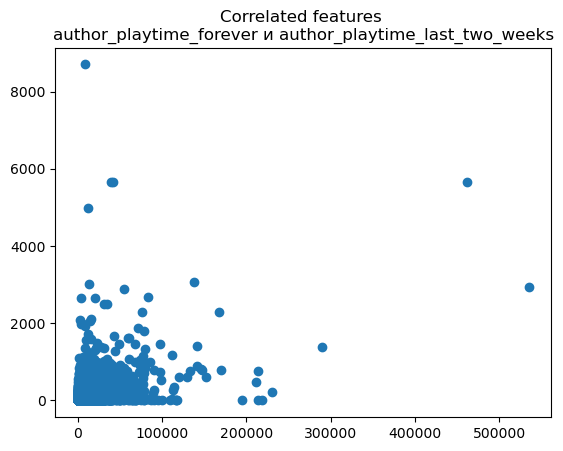

In [49]:
plot_correlated_features(df_games, 'author_playtime_forever', 
                         'author_playtime_last_two_weeks')

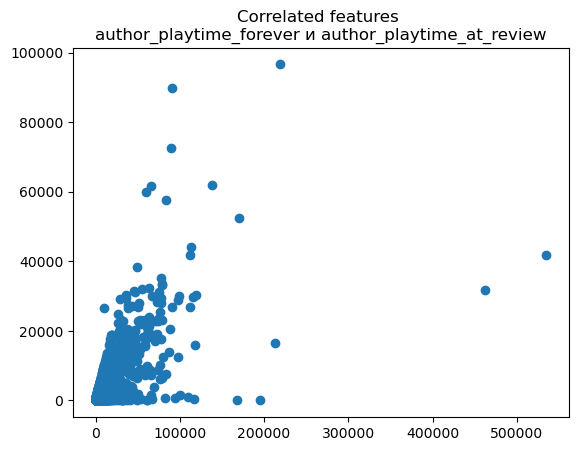

In [50]:
plot_correlated_features(df_games, 'author_playtime_forever', 
                         'author_playtime_at_review')

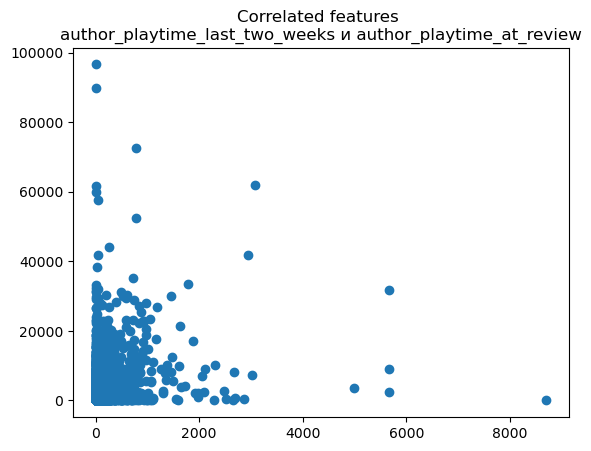

In [51]:
plot_correlated_features(df_games, 'author_playtime_last_two_weeks', 
                         'author_playtime_at_review')

## Conclusions

- outlier processing is necessary
- we see that people play a lot of games and write a lot of reviews, so it may be reasonable to keep only the most active users and the most popular games for further modeling
- there are correlated features, but not many, it is necessary to select one of the correlated features when building models

# Additional analysis when filtering out "thrash" games

In [52]:
df["TotalReviews"] = df_games["Positive"] + df_games["Negative"]

df_popular_50 = df.query("TotalReviews >= 50")
df_popular_70 = df.query("TotalReviews >= 70")
df_popular_100 = df.query("TotalReviews >= 100")

df_popular = df.query("TotalReviews >= 100")

In [53]:
df.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,AppID,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,TotalReviews
count,7.114800e+04,71148.000000,71148.000000,71148.000000,71148.000000,7.114800e+04,7.114800e+04,71135.000000,71135.000000,61919.000000,7.114800e+04
mean,1.226345e+06,0.740584,0.625439,0.093067,0.140561,4.291347e+03,4.788559e+02,1287.229734,10.946197,449.447866,1.275111e+03
std,6.291145e+05,0.235482,0.346179,0.150691,0.325188,5.858577e+05,2.799471e+04,5819.748655,85.242599,1561.888567,3.056097e+04
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,0.001074,0.000000,5.000000,0.000000e+00
1%,3.385580e+04,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,9.000000,0.000000,8.000000,0.000000e+00
5%,3.019135e+05,0.267072,0.000000,0.000000,0.000000,0.000000e+00,8.000000e+00,21.566667,0.000000,16.300000,0.000000e+00
10%,3.989270e+05,0.417220,0.000000,0.000000,0.000000,6.120458e+01,1.600000e+01,37.122727,0.000000,25.714286,0.000000e+00
25%,7.011450e+05,0.621193,0.389455,0.000000,0.000000,1.739134e+02,4.100000e+01,93.202273,0.000000,58.000000,2.000000e+00
50%,1.190085e+06,0.800000,0.750000,0.036145,0.000000,3.829989e+02,1.186090e+02,264.017953,0.000000,144.031250,1.400000e+01
75%,1.731600e+06,0.922731,0.911864,0.114286,0.000000,8.168813e+02,3.565890e+02,773.423706,1.272215,362.061522,8.400000e+01


In [54]:
df_popular_50.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,AppID,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,TotalReviews
count,2.214600e+04,22146.000000,22146.000000,22146.000000,22146.000000,2.214600e+04,22146.000000,22140.000000,22140.000000,19354.000000,2.214600e+04
mean,1.230237e+06,0.741098,0.626703,0.092770,0.141644,7.410487e+03,345.865389,1300.319535,10.383721,437.972804,4.074009e+03
std,6.260539e+05,0.234902,0.345584,0.148949,0.325907,9.603623e+05,654.773043,6202.473358,73.201151,1397.826586,5.467425e+04
min,4.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.666667,0.000000,5.000000,5.000000e+01
1%,3.721900e+04,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000,9.608571,0.000000,8.000000,5.100000e+01
5%,3.082025e+05,0.272727,0.000000,0.000000,0.000000,4.000000e-01,8.142857,22.000000,0.000000,16.493519,5.600000e+01
10%,4.084250e+05,0.421053,0.000000,0.000000,0.000000,6.320067e+01,16.131973,37.973187,0.000000,26.166667,6.400000e+01
25%,7.072425e+05,0.624299,0.400000,0.000000,0.000000,1.779690e+02,41.788999,94.424370,0.000000,59.407143,9.800000e+01
50%,1.192925e+06,0.800000,0.750000,0.036874,0.000000,3.906062e+02,120.468830,263.872984,0.000000,145.359323,2.390000e+02
75%,1.732338e+06,0.922484,0.911659,0.113636,0.000000,8.210341e+02,356.081096,760.527778,1.235682,362.583051,8.780000e+02


In [55]:
df_popular_70.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,AppID,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,TotalReviews
count,1.926900e+04,19269.000000,19269.000000,19269.000000,19269.000000,1.926900e+04,19269.000000,19264.000000,19264.000000,16868.000000,1.926900e+04
mean,1.230100e+06,0.741729,0.626779,0.093003,0.142137,8.414736e+03,346.664781,1311.394293,10.339755,437.035560,4.673511e+03
std,6.233365e+05,0.234369,0.345099,0.148309,0.326570,1.029563e+06,655.060884,6123.840191,71.913511,1346.459305,5.859053e+04
min,4.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.666667,0.000000,5.000000,7.000000e+01
1%,3.801680e+04,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000,10.000000,0.000000,8.000000,7.100000e+01
5%,3.082600e+05,0.272727,0.000000,0.000000,0.000000,2.000000e+00,8.428571,22.000000,0.000000,16.586316,7.900000e+01
10%,4.110520e+05,0.426090,0.000000,0.000000,0.000000,6.486275e+01,16.250000,37.892222,0.000000,26.000000,8.900000e+01
25%,7.112300e+05,0.625000,0.400000,0.000000,0.000000,1.790498e+02,42.125000,94.000000,0.000000,59.328947,1.340000e+02
50%,1.194330e+06,0.800000,0.750000,0.037037,0.000000,3.911744e+02,121.064103,262.269298,0.000000,144.698065,3.150000e+02
75%,1.728960e+06,0.922780,0.910569,0.115385,0.000000,8.205182e+02,356.353846,760.527778,1.255047,362.461017,1.125000e+03


In [56]:
df_popular_100.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,AppID,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,TotalReviews
count,1.652900e+04,16529.000000,16529.000000,16529.000000,16529.000000,1.652900e+04,16529.000000,16524.000000,16524.000000,14443.000000,1.652900e+04
mean,1.230779e+06,0.741796,0.625816,0.092969,0.140140,9.699461e+03,348.406204,1316.868135,10.212850,433.604367,5.434418e+03
std,6.232746e+05,0.235201,0.345604,0.147950,0.324478,1.111627e+06,655.400668,6307.338982,71.975281,1357.844338,6.322874e+04
min,4.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,5.000000,0.000000,5.000000,1.000000e+02
1%,3.752480e+04,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000,9.571429,0.000000,8.000000,1.020000e+02
5%,3.068640e+05,0.272727,0.000000,0.000000,0.000000,0.000000e+00,8.347872,22.000000,0.000000,16.500000,1.120000e+02
10%,4.100660e+05,0.423840,0.000000,0.000000,0.000000,6.317840e+01,16.000000,37.225714,0.000000,26.000000,1.260000e+02
25%,7.114500e+05,0.625000,0.390625,0.000000,0.000000,1.790000e+02,42.333333,94.162295,0.000000,59.000000,1.880000e+02
50%,1.196590e+06,0.800000,0.750000,0.037037,0.000000,3.921732e+02,121.502276,262.000000,0.000000,144.333333,4.230000e+02
75%,1.730360e+06,0.923077,0.910714,0.115385,0.000000,8.255667e+02,359.133333,755.349415,1.192345,359.767718,1.461000e+03


**Conclusions:**
- The variability in the percentage of positive reviews (voted_up) is much higher for popular games
- For popular games, the percentage of people who got them for free is lower
- The percentage of people who wrote reviews during early access is also smaller for popular games
- For popular games, the number of games that reviewers play and the number of reviews people write is greater
- For popular games, there is more time that people play them at all and at the time the review was written

In [57]:
language_counter = FeatureCounter('language', N_JOBS)
dict_languages = language_counter.get_all_feature_counts()

sorted_lang = sorted(dict_languages.items(), key=lambda item: item[1], reverse=True)
sorted_lang_df = pd.DataFrame(sorted_lang[:10], columns=['language', 'Count'])

Total time: 84.67502784729004


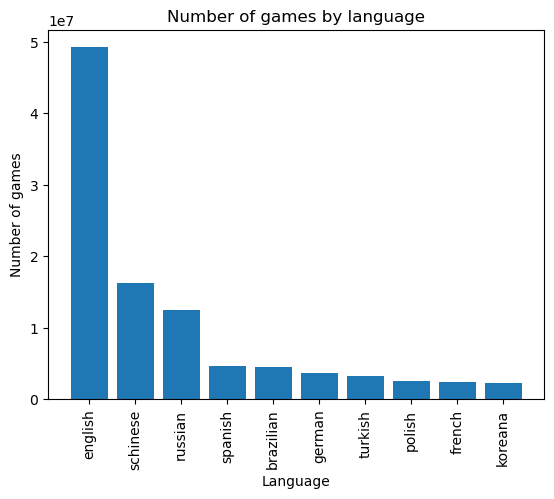

In [58]:
make_barplot('language', sorted_lang_df, 
             'Language', 'language', rotation=True, pre_counted = True)

**Видим, что для популярных игр значительно больше отзывов на русском языке и заметно меньше на китайском**

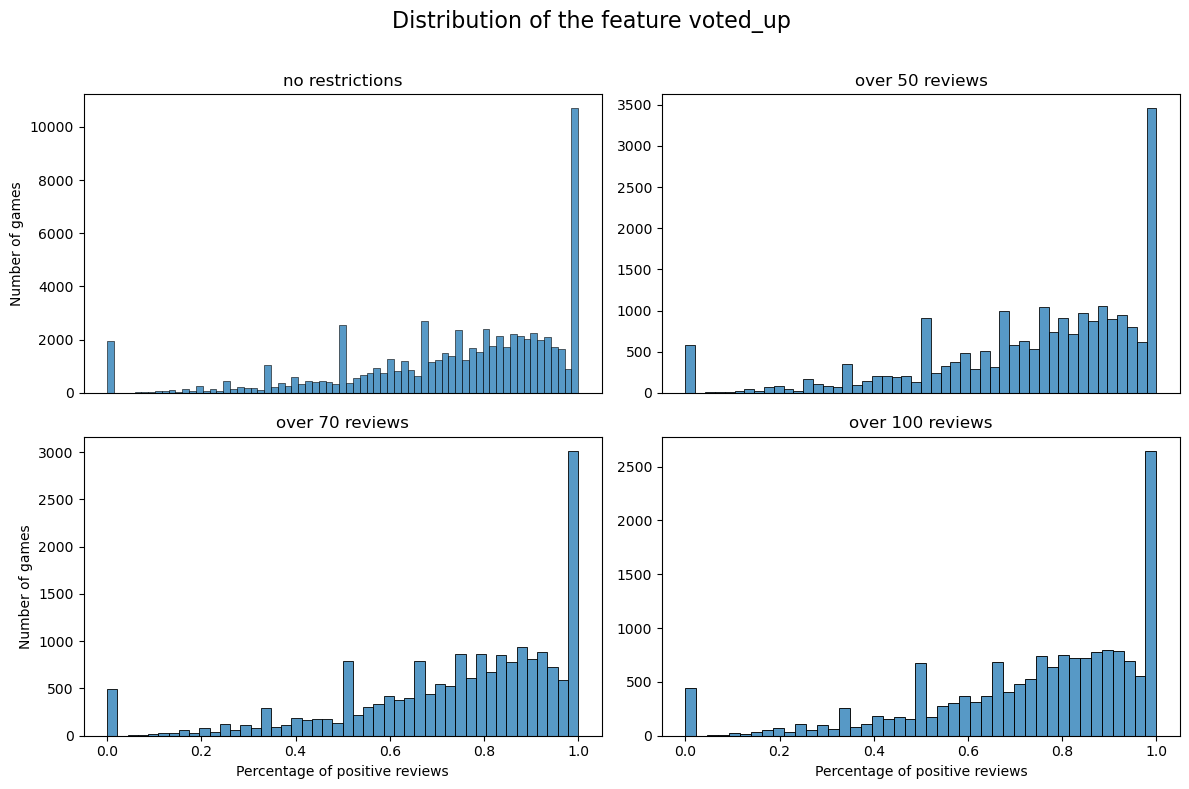

In [59]:
make_histplot_filtr('voted_up', [df, df_popular_50, df_popular_70, df_popular_100], 
                    'Percentage of positive reviews', rotation=False)

**Видим, что для популярных игр более плавно распределена доля положительных отзывов. И в целом положительных отзывов больше**

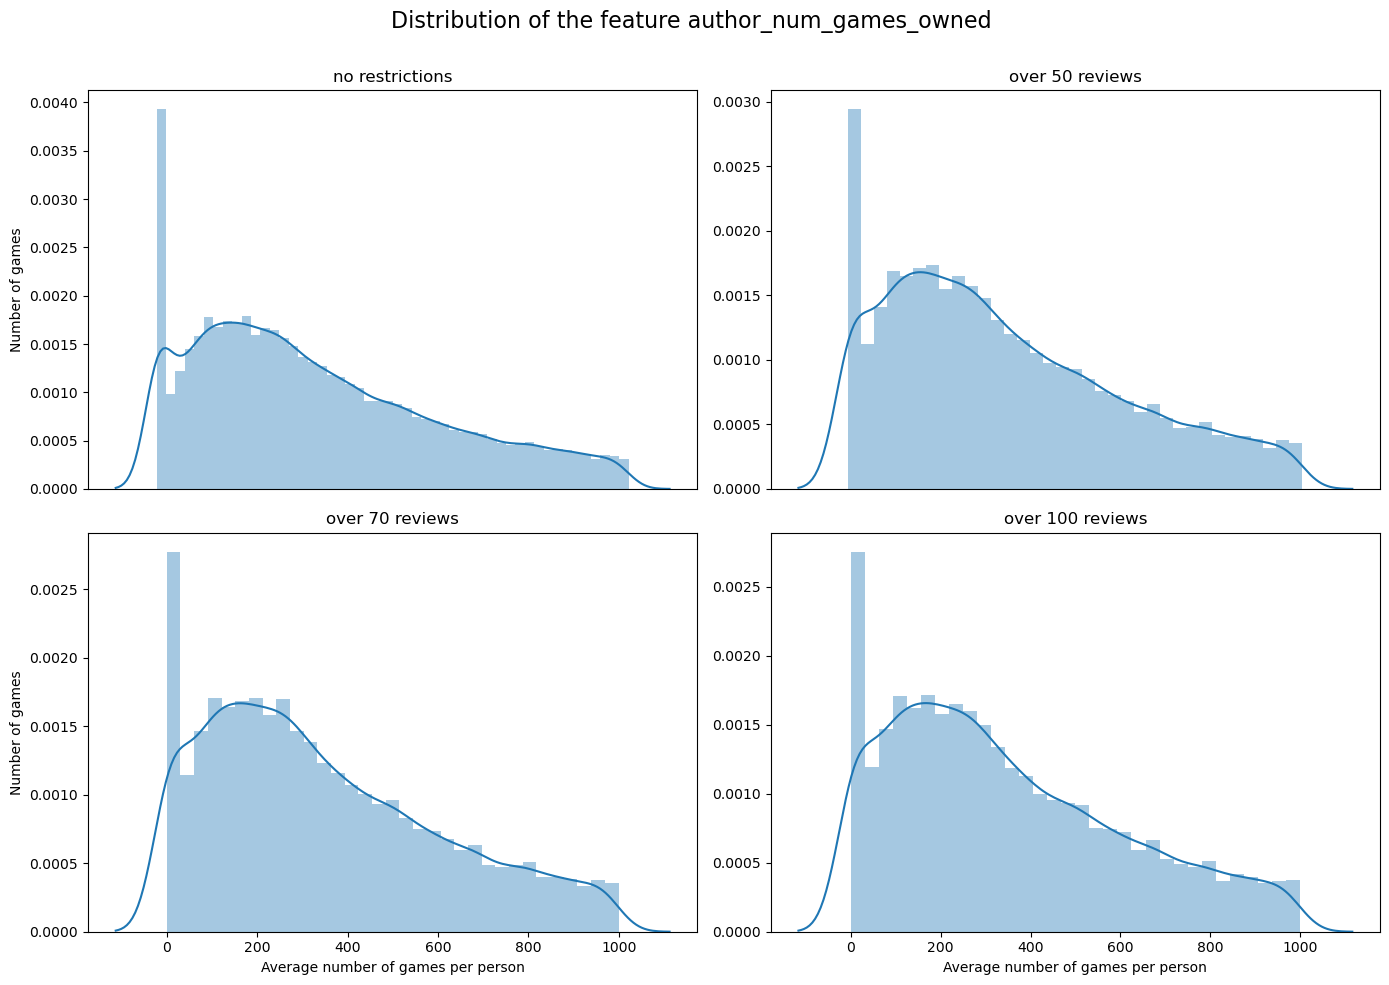

In [60]:
make_distplot_filtr('author_num_games_owned', 
                    [df, df_popular_50, df_popular_70, df_popular_100], 
                    'Average number of games per person', 
                    rotation=False, x_max = 1000)

**Видим, что для популярных игр меньше количество людей, которые играют в маленькое количество игр (около нуля)**

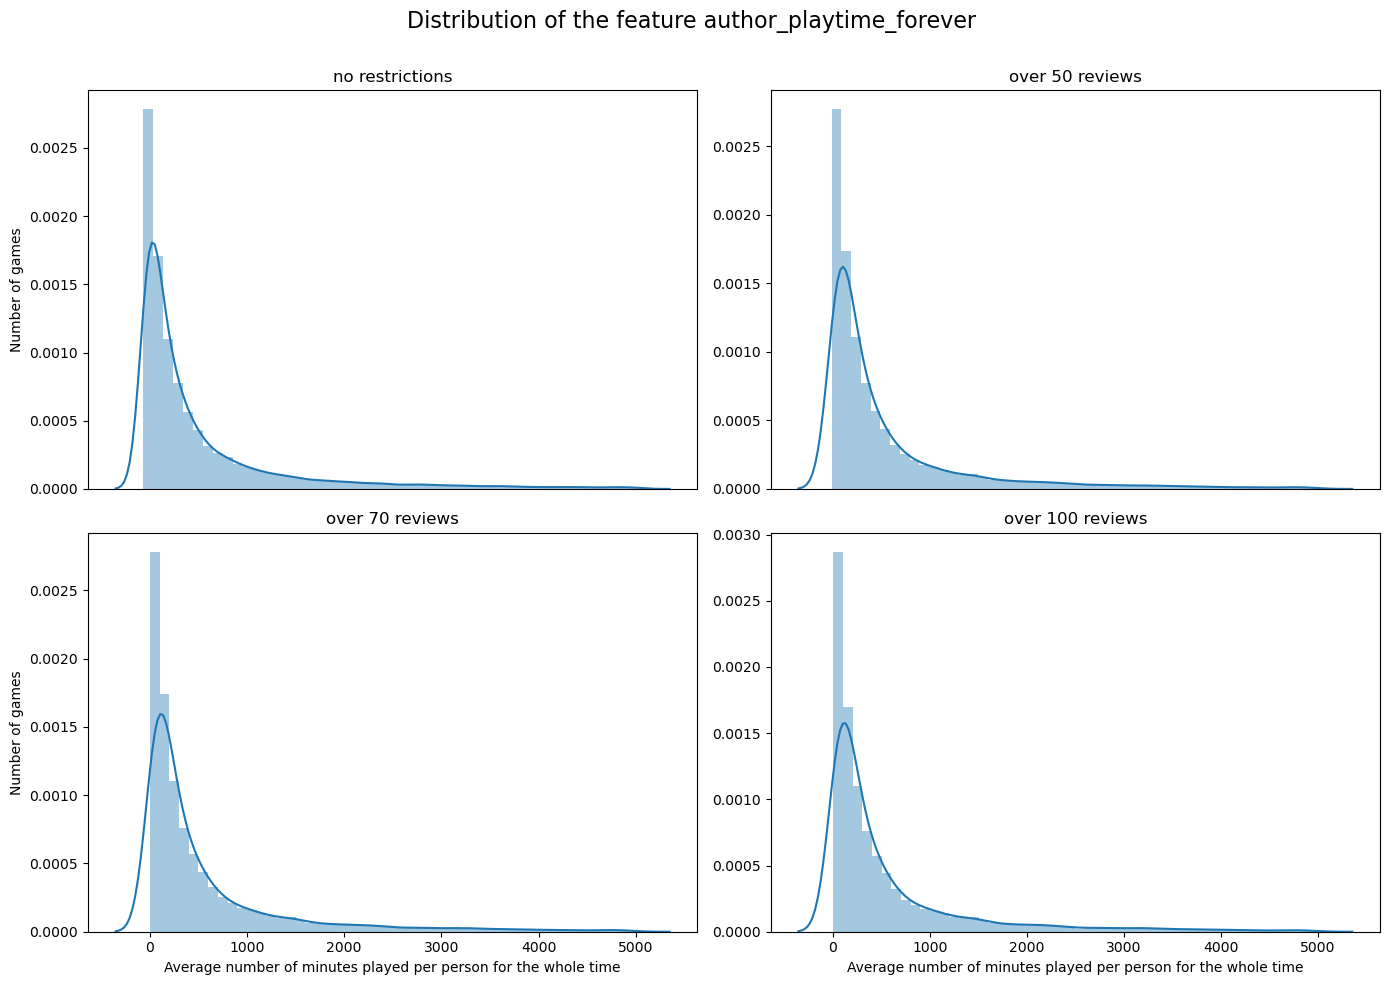

In [61]:
make_distplot_filtr('author_playtime_forever', 
                    [df, df_popular_50, df_popular_70, df_popular_100], 
                    'Average number of minutes played per person for the whole time', 
                    rotation=False, x_max = 5000)

**We see that more time is spent in popular games**

# Part 2. Grouping by user

## Collecting data in a dataframe

In [62]:
# def get_data(feature_list, file_path: str):
#     df = pd.read_csv(file_path)
#     return df[['author_steamid'] + feature_list]

feature_list = ['voted_up', 'author_num_games_owned', 'author_num_reviews',
               'author_playtime_forever', 'author_playtime_last_two_weeks', 
                'author_playtime_at_review']

N_JOBS = 4
start_time = time.time()
games_language_counts = Parallel(n_jobs=N_JOBS)(
    delayed(get_data)(feature_list, game_file_path) 
    for game_file_path in game_review_files)
end_time = time.time()
print("Total time:", end_time - start_time)

merged_df = pd.concat(games_language_counts)

Total time: 158.98852705955505


In [63]:
df_users = merged_df.groupby(by=['author_steamid']).mean()

## Descriptive statistics

In [64]:
df_users.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,voted_up,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
count,2.693465e+07,2.693465e+07,2.693465e+07,2.693465e+07,2.693465e+07,2.692293e+07
mean,8.636858e-01,9.155000e+04,1.143034e+05,2.151464e+04,1.753052e+02,1.125054e+04
std,2.768066e-01,2.314067e+08,4.563553e+08,4.907206e+04,6.628503e+02,2.995895e+04
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
1%,0.000000e+00,0.000000e+00,1.000000e+00,4.052419e+01,0.000000e+00,2.400000e+01
5%,0.000000e+00,0.000000e+00,1.000000e+00,3.210000e+02,0.000000e+00,1.800000e+02
10%,5.000000e-01,0.000000e+00,1.000000e+00,6.850000e+02,0.000000e+00,3.070000e+02
25%,8.571429e-01,3.500000e+00,1.000000e+00,2.081333e+03,0.000000e+00,8.480000e+02
50%,1.000000e+00,1.900000e+01,1.666667e+00,6.400500e+03,0.000000e+00,2.657167e+03
75%,1.000000e+00,5.666667e+01,3.100000e+00,1.991777e+04,5.400000e+01,8.987250e+03


## Plotting the distributions

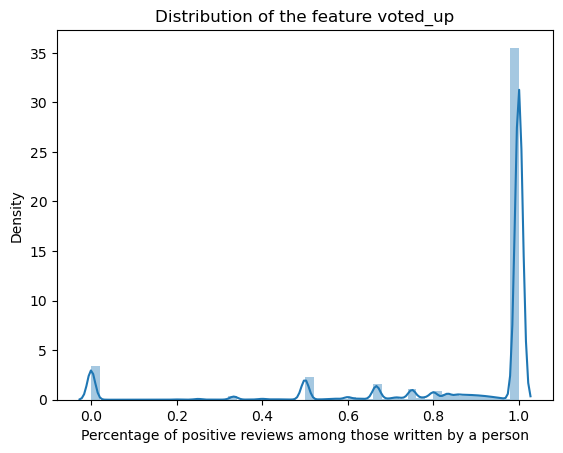

In [65]:
make_distplot('voted_up', df_users, 
              'Percentage of positive reviews among those written by a person', 
              rotation=False)

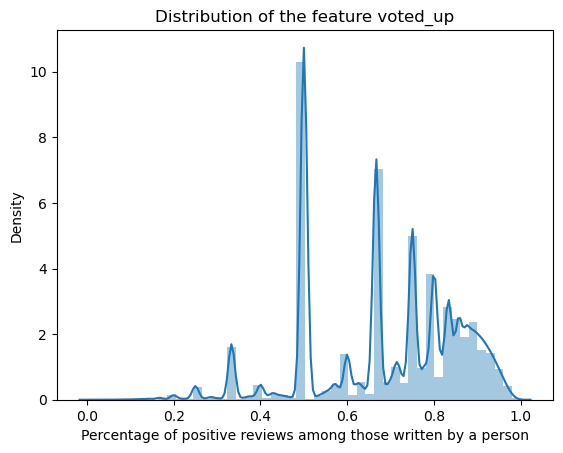

In [66]:
make_distplot('voted_up', df_users[(df_users['voted_up'] != 0) 
                                   & (df_users['voted_up'] != 1)], 
              'Percentage of positive reviews among those written by a person', 
              rotation=False)

**Видим, что в основном люди чаще пишут положительные отзывы**

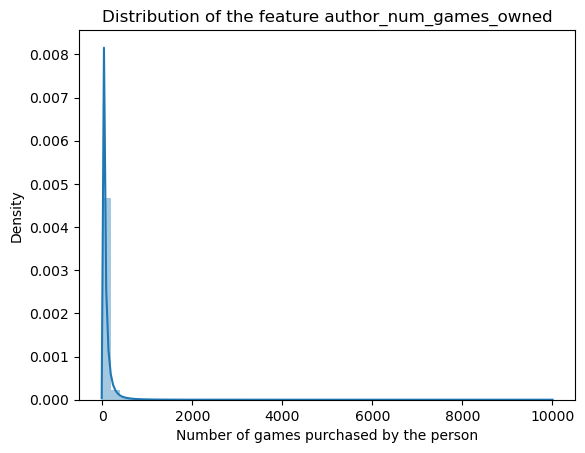

In [67]:
make_distplot('author_num_games_owned', 
              df_users[(df_users['author_num_games_owned'] != 0) 
                       & (df_users['author_num_games_owned'] < 10_000)], 
              'Number of games purchased by the person', 
              rotation=False)

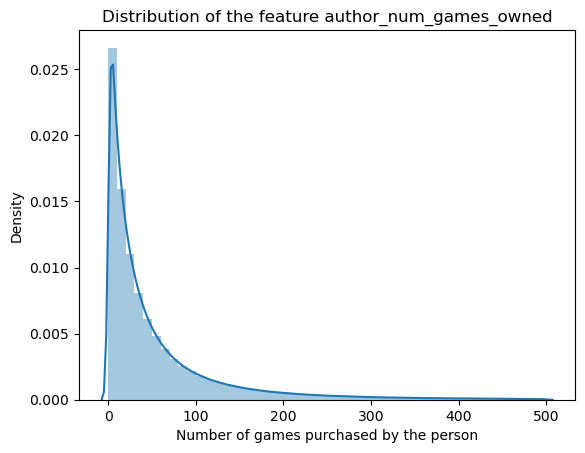

In [68]:
make_distplot('author_num_games_owned', 
              df_users[(df_users['author_num_games_owned'] != 0) 
                       & (df_users['author_num_games_owned'] < 500)], 
              'Number of games purchased by the person', 
              rotation=False)

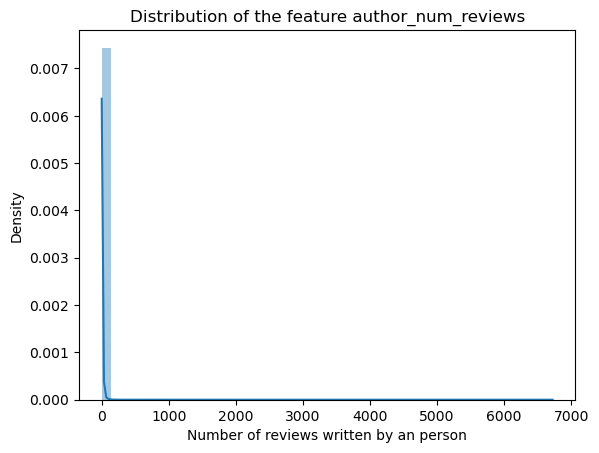

In [69]:
make_distplot('author_num_reviews', 
              df_users[(df_users['author_num_reviews'] != 0) 
                       & (df_users['author_num_reviews'] < 10_000)], 
              'Number of reviews written by an person', 
              rotation=False)

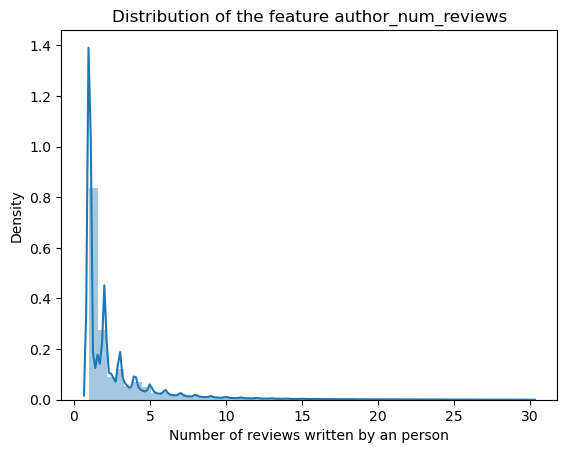

In [70]:
make_distplot('author_num_reviews', 
              df_users[(df_users['author_num_reviews'] != 0) 
                       & (df_users['author_num_reviews'] < 30)], 
              'Number of reviews written by an person', 
              rotation=False)

**В основном один человек пишет до 5-10 отзывов**

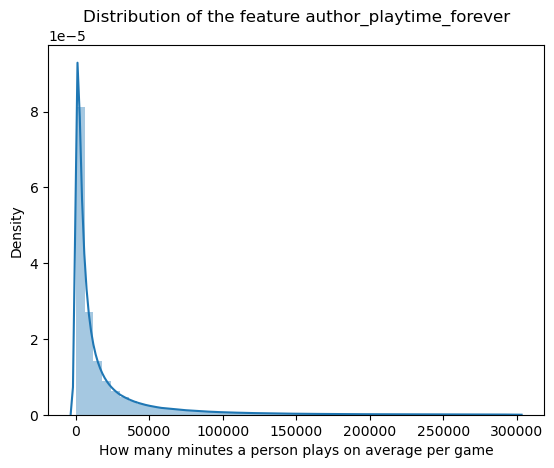

In [71]:
make_distplot('author_playtime_forever', 
              df_users[(df_users['author_playtime_forever'] != 0) 
                       & (df_users['author_playtime_forever'] < 300_000)], 
              'How many minutes a person plays on average per game', 
              rotation=False)

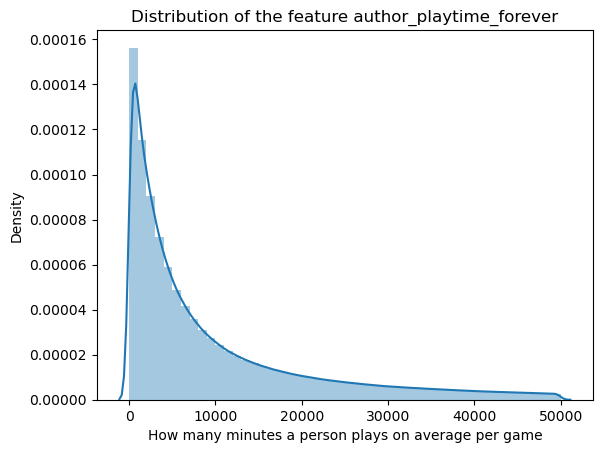

In [72]:
make_distplot('author_playtime_forever', 
              df_users[(df_users['author_playtime_forever'] != 0) 
                       & (df_users['author_playtime_forever'] < 50_000)], 
              'How many minutes a person plays on average per game', 
              rotation=False)

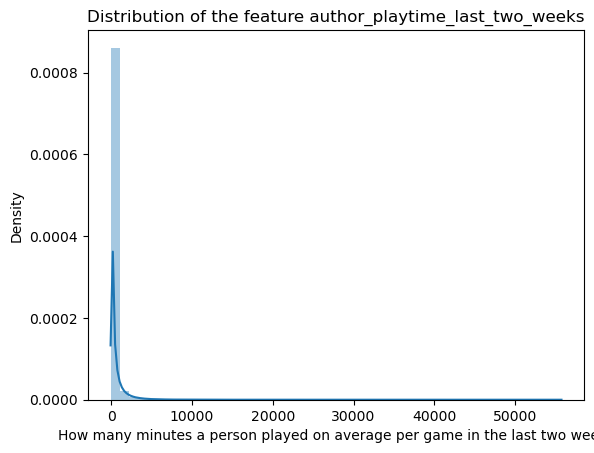

In [73]:
make_distplot('author_playtime_last_two_weeks', df_users, 
              'How many minutes a person played on average per game in the last two weeks', 
              rotation=False)

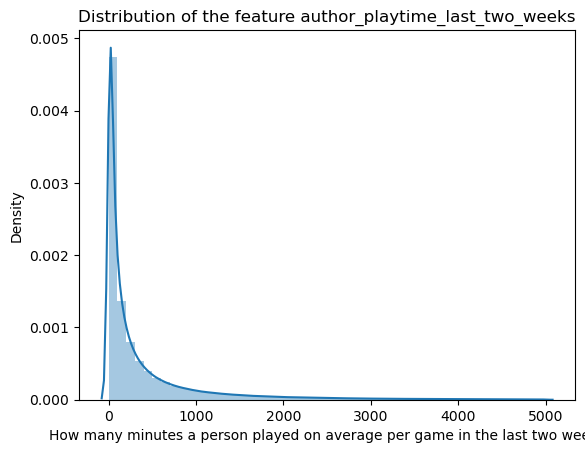

In [74]:
make_distplot('author_playtime_last_two_weeks', 
              df_users[(df_users['author_playtime_last_two_weeks'] != 0) 
                       & (df_users['author_playtime_last_two_weeks'] < 5_000)], 
              'How many minutes a person played on average per game in the last two weeks', 
              rotation=False)

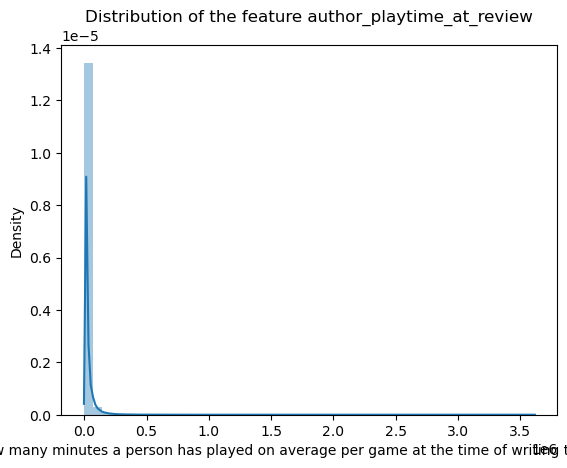

In [75]:
make_distplot('author_playtime_at_review', df_users, 
              'How many minutes a person has played on average per game at the time of writing the reviews', 
              rotation=False)

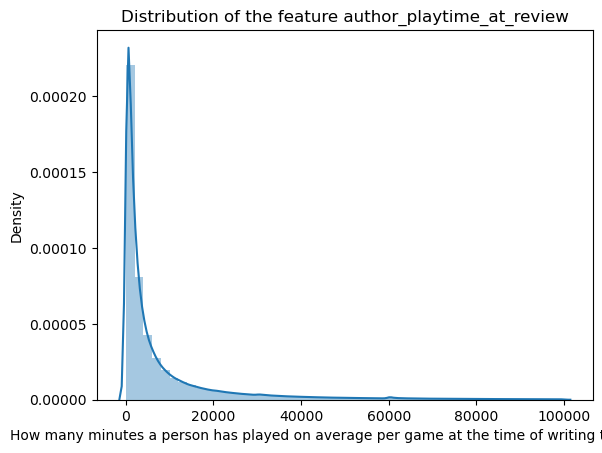

In [76]:
make_distplot('author_playtime_at_review', 
              df_users[(df_users['author_playtime_at_review'] != 0) 
                       & (df_users['author_playtime_at_review'] < 100_000)], 
              'How many minutes a person has played on average per game at the time of writing the reviews', 
              rotation=False)

## Корреляционный анализ

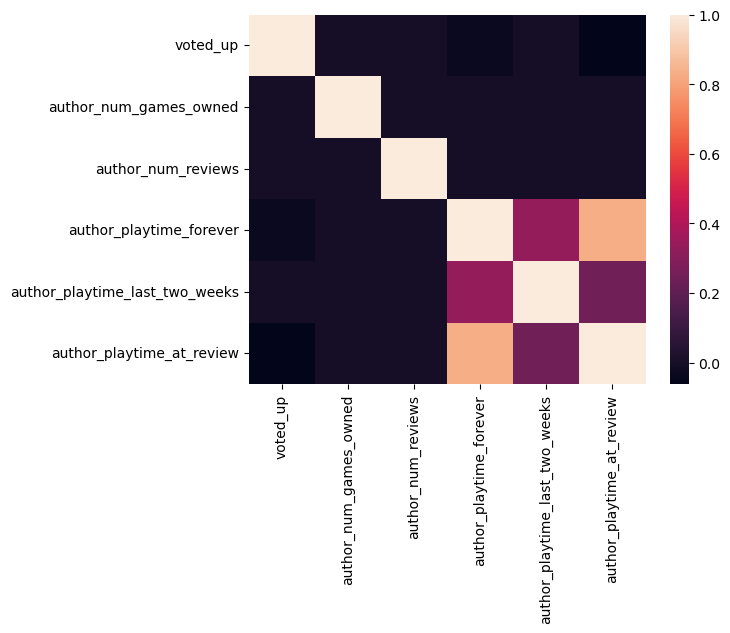

In [77]:
corr_matrix = df_users.corr()
sns.heatmap(corr_matrix)
plt.show()

**We see that all the same signs are correlated playtime forever / last two weeks / at review**.

# Results:
- When dividing by users and games, we can observe the same trends for the attributes
- It is important to take active users and popular games to further build the recommendation system, as we observe different trends for them and less active users/less popular games.
- It is also important to work with outliers and correlated features before building the models